Name: Ivan Morrow

# A2: NeuralNetwork Class

In this assignment, you will implement a class named `NeuralNetwork` using code from lecture notes.  To do this, follow these steps.


1. Define the `__init__(self, n_inputs, n_hiddens_each_layer, n_outputs)` function with `n_inputs` as the number of input components in each sample (columns of `X`), `n_hiddens_each_layer` as the number of units in each hidden layer, and `n_outputs` as the number of outputs of the output layer. The length of `n_hiddens_each_layer` determines the number of hidden layers in the created neural network. The `__init__` functions must
 
    1. assign these values to member variables `self.n_inputs`, `self.n_hiddens_each_layer`, and `self.n_outputs`,
    1. initialize `self.rmse_trace` to an empty list,
    2. initialize `self.n_epochs` to 0,
    1. initialze `self.X_means` to `None` to indicate that `X` and `T` have not yet been standardized, and
    2. build in `self.Ws` a list of two-dimensional numpy arrays as weight matrices, one for each hidden layer, with uniformly distributed random values between -1 and 1 divided by the square root of the number of inputs to the corresponding layer. Append one more weight matrix of all zero values for the weight matrix in the output layer.

1. Define `__repr__(self)` and `__str__(self)` functions that return strings as shown in the examples in this notebook.

2. Define `_calc_rmse_standardized(self, Y, T` as shown in lecture notes.

1. Define the `_forward(self, X)` function that accepts `X` as standardized values, creates `self.Zs` as a list consisting of the input `X` and the outputs of each hidden layer and the output layer for all samples in `X` and returns the output of the network, `Y`, in standardized form.
  
1. Define  the `_gradients(self, X, T)` function that accepts `X` and `T` as standardized values and returns a list of numpy arrays containing the gradients of the mean square error with respect to the weights in each layer, in the order of the layers from the first hidden layer, second hidden layer, and so on,  to the output layer.
  
1. Define the `train(self, Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs, learning_rate)` function that

    1. if `self.X_means` is `None`, standardizes `Xtrain` and `Ttrain` and saves the standardization parameters (means and stds) in member variables, `self.X_means`, `self.X_stds`, `self.T_means` and `self.T_stds`,
    1. standardizes `Xvalidate` and `Tvalidate` using `self.X_means`, `self.X_stds`, `self.T_means` and `self.T_stds`,
    1. loops for `n_epochs` as shown in notes `05` and for each loop,

        1. uses the `_forward` function to calculate the outputs of all units,
        1. uses the `_gradients` function to calculate the gradient of the the mean squared error respect to all weight matrices,
        1. updates all weight matrices using the gradients returned from `_gradients` using SGD, meaning the learning rate multiplied by the gradient,
        1. calculates the RMSE for train and validation data and appends a list of these two values to the list `self.rmse_trace`, and
    1. increments `self.n_epochs` by `n_epochs`.

1. Define `use(self, X)` that

    1. standardizes `X` using the standardization member variables,
    1. calls `_forward` to calculate the outputs of all units,
    1. unstandardizes the output of the network and returns it.

1. You may choose to define other functions, such as `_add_ones`, to be called by the functions above. Remember to name functions with a leading `_` that are not meant to be called by the users of your `NeuralNetwork` class.

In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd  # for display and clear_output
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
class NeuralNetwork:
    def __init__(self, n_inputs, n_hiddens_each_layer, n_outputs):
        self.n_inputs = n_inputs
        self.n_hiddens_each_layer = n_hiddens_each_layer
        self.n_outputs = n_outputs
        self.rmse_trace = []
        self.n_epochs = 0
        self.X_means = None
        self.Ws = self._initialize_w()

    def __repr__(self):
        return 'NeuralNetwork({}, {}, {}'.format(self.n_inputs, self.n_hiddens_each_layer, self.n_outputs)

    def __str__(self):
        if self.n_epochs is not None:
            return f'{self.__repr__()} trained for {self.n_epochs} epochs with a final RMSE of {self.rmse_trace[-1][0]}.'   
        else:
            return f'{self.__repr__()} has not been trained.'
    
    def _initialize_w(self):
        """
        Args:
            self: NeuralNetwork class

        Iterates over each layer of NN and fetches the number of units in each given layer from self.n_hiddens_each_layer.
        If looking at the very first layer, use the model inputs as the units_prev_layer variable. Otherwise,
        fetch the units in the previous hidden layer from n_hiddens_each_layer using the index.

        Creates a Numpy array of weights for the given layer based on its num of units and the units in the prev
        layer. Appends these to a running list W.

        Finally, appends an array of all 0s as the final layer to W for the weight matrix in the output layer.
        """
        W = []
        if len(self.n_hiddens_each_layer) >= 1:
            for layer in range(len(self.n_hiddens_each_layer)):
                units_in_layer = self.n_hiddens_each_layer[layer]
                if layer == 0:
                    units_prev_layer = self.n_inputs
                else:
                    units_prev_layer = self.n_hiddens_each_layer[layer - 1]
                W.append(np.random.uniform(-1, 1, size=(1 + units_prev_layer, units_in_layer)) / np.sqrt(1 + units_in_layer))
            
            # append 0's for the weight matrix of output layer
            W.append(np.zeros(shape=(1 + self.n_hiddens_each_layer[-1], self.n_outputs)))
        else:
            W.append(np.zeros(shape=(1 + self.n_inputs, self.n_outputs)))

        return W

    def _calc_rmse_standardized(self, T, Y):
        # multiply by std. dev. of T to undo std. dev. operation
        error = (T - Y) * self.T_stds
        return np.sqrt(np.mean(error**2)) 

    # Add constant column of 1's
    def _add_ones(self, A):
        return np.insert(A, 0, 1, axis=1)

    # standardize matrix data
    def _standardize(self, matrix, means=None, stds=None):
        if means is None and stds is None:
            means = matrix.mean(axis=0)
            stds = matrix.std(axis=0)

        standardized_matrix = (matrix - means) / stds
        return standardized_matrix, means, stds

    def _forward(self, X):
        self.Zs = []
        self.Zs.append(X)
        input = X
        for i, weights in enumerate(self.Ws):
            # add ones to input matrix for mat mul with weights & biases
            input = self._add_ones(input)
            # apply tanh activation function on all hidden layers
            if i < len(self.Ws) - 1:
                layer_output = np.tanh(input @ weights)
            # no activation function on output layer
            else:
                layer_output = input @ weights
    
            self.Zs.append(layer_output)
            input = layer_output

        # input holds result from output_layer of model
        return input
    
    def _gradients(self, X, T, verbose=False):
        gradients = []
        # Start with the output layer
        error = (self.Zs[-1] - T) / self.n_inputs * self.n_outputs
        if verbose:
            self._start_gradients_message(error)
        
        for layer in range(len(self.Ws) - 1, -1, -1):
            print('layer: ', layer)
            
            # Current layer's activations
            current_activations = self.Zs[layer]
            # Compute gradient for current layer's weights
            grad_wrt_W = -current_activations.T @ error
            
            # Calculate gradient for biases
            grad_wrt_b = - np.sum(error, axis=0, keepdims=True)
            
            full_gradient = np.vstack([grad_wrt_b, grad_wrt_W])
            
            gradients.insert(0, full_gradient)
                    
            # If not the input layer, propagate error to previous layer
            if layer > 0:
                error = error @ self.Ws[layer][1:, :].T
                
                if self.Zs[layer-1][1].shape == (1,):
                    prev_activations = self.Zs[layer-1]
                else:
                    prev_activations = self.Zs[layer-1][:, 1:]
                    
                # Apply derivative of activation function
                error = error * (1 - prev_activations**2)

            if verbose:
                self._print_gradients_progress(layer, gradients, error)
        print('Returning reversed list of gradients.')
        return gradients
        
    def _start_gradients_message(self, output_error):
        print('In _gradients, just before for loop.\nShapes of self.Zs elements: {}'.format(
            ', '.join(str(z.shape) for z in self.Zs)
        ))
        print('In _gradients, just before for loop.\nShapes of self.Ws elements: {}'.format(
            ', '.join(str(w.shape) for w in self.Ws)
        ))
        print('delta (backpropped from output layer) is ', output_error)
        print('gradients list is empty.\n')
        
    def _print_gradients_progress(self, loop, gradients, delta):
        index = len(self.Ws) - loop
        print('End of Pass {} through _gradients for loop:'.format(index))
        print('shapes of elements in gradients list are {}'.format(
            ', '.join(str(x.shape) for x in gradients)
        ))
        print('shapes of updated delta is {}'.format(delta.shape))
        for i in range(len(gradients)):
            print('element {} of gradients list is: {}'.format(
                i+1,
                gradients[i]
            ))
        print('\n')

    
    def train(self, Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs, learning_rate, verbose=False):
        if self.X_means is None:
            XtrainStd, self.X_means, self.X_stds = self._standardize(Xtrain)
            TtrainStd, self.T_means, self.T_stds = self._standardize(Ttrain)
        XvalidateStd, _, _ = self._standardize(Xvalidate, self.X_means, self.X_stds)
        TvalidateStd, _, _ = self._standardize(Tvalidate, self.T_means, self.T_stds)
        for epoch in range(n_epochs):
            print('Epoch is {}. # printed from _train'.format(epoch))
            
            # Forward pass on all training data
            Y = self._forward(XtrainStd)
            
            # Calculate Gradients of error w.r.t. all weights
            gradients = self._gradients(Y, TtrainStd, verbose=verbose)

            # Update weight matrices using gradients
            for i, weights in enumerate(self.Ws):
                print('Taking SGD step...')
                self.Ws[i] += weights - learning_rate * gradients[i]
                
            # calculate error in predictions
            epoch_error = self._calc_rmse_standardized(TtrainStd, Y)
            
            # validation
            val_Y = self._forward(XvalidateStd)
            val_error = self._calc_rmse_standardized(TvalidateStd, val_Y)
            
            # append errors
            self.rmse_trace.append([epoch_error, val_error])
            
            self.n_epochs += n_epochs

    def use(self, X):
        # standardize input
        if self.X_means is None:
            X, _, _ = self._standardize(X, self.X_means, self.X_stds)
        
        # predict with model
        Ys = self._forward(X)
        
        # unstandardize model output
        Y = (Ys*self.X_stds) + self.X_means
        
        return Y

In [7]:
# During development of your `NeuralNetwork` class, you may develop it in a python script file.  
# Then, to test it you may import it by uncommenting the last line in this cell which assumes 
# your python script is in `A2mysolution.py`.

# Before you check in your notebook, copy and paste the whole `NeuralNetwork` class definition into the
# above cell, and delete this cell.

# from A2solution import NeuralNetwork, create_model

In this next code cell, I add a new method to your class that replaces the weights created in your constructor with non-random values to allow you to compare your results with mine, and to allow our grading scripts to work well. 

In [8]:
def set_weights_for_testing(self):
    # Set weights in hidden layers
    for W in self.Ws[:-1]:
        n_weights = W.shape[0] * W.shape[1]
        W[:] = np.linspace(-0.01, 0.01, n_weights).reshape(W.shape)
        for u in range(W.shape[1]):
            W[:, u] += (u - W.shape[1]/2) * 0.2
            
    # Set output layer weights to zero
    self.Ws[-1][:] = 0

setattr(NeuralNetwork, 'set_weights_for_testing', set_weights_for_testing)

In [9]:
### GRADE TEST CASE RUNS MANUALLY BUT FAILS IN THE SCRIPT? NOT SURE WHY.

n_inputs = 3
n_hiddens = [2, 1]
n_outputs = 2
n_samples = 5

X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
T = np.hstack((X, X*2))

nnet = NeuralNetwork(n_inputs, n_hiddens, n_outputs)
nnet.set_weights_for_testing()

# Set standardization variables so use() will run
nnet.X_means = 0
nnet.X_stds = 1
nnet.T_means = 0
nnet.T_stds = 1

Y = nnet.use(X)

Y_correct = np.array([[0., 0.],
    [0., 0.],
    [0., 0.],
    [0., 0.],
    [0., 0.]])
np.allclose(Y, Y_correct, 0.1)

True

Now test your implementation, using example shown below and additional tests of your own creation.

In [10]:
X = np.arange(0, 6 * 6).reshape(-1, 6)
T = np.sin(X[:, 0:1])
n_inputs = X.shape[1]
n_hiddens_each_layer = [5, 4, 3, 2]
n_outputs = T.shape[1]
nnet = NeuralNetwork(n_inputs, n_hiddens_each_layer, n_outputs)
nnet.set_weights_for_testing()
nnet.train(X, T, X, T, n_epochs=3, learning_rate=0.2, verbose=True)

Epoch is 0. # printed from _train
In _gradients, just before for loop.
Shapes of self.Zs elements: (6, 6), (6, 5), (6, 4), (6, 3), (6, 2), (6, 1)
In _gradients, just before for loop.
Shapes of self.Ws elements: (7, 5), (6, 4), (5, 3), (4, 2), (3, 1)
delta (backpropped from output layer) is  [[-0.27553167]
 [-0.14204938]
 [-0.0192002 ]
 [ 0.08322975]
 [ 0.15708098]
 [ 0.19647053]]
gradients list is empty.

layer:  4
Current activations shape: (6, 2)
Current error shape: (6, 1)
Weight gradient shape: (2, 1)
Full gradient shape: (3, 1)
Shape of prev_activation: (6, 2)
shape of error: (6, 2)
Propagated error shape: (6, 2)
End of Pass 1 through _gradients for loop:
shapes of elements in gradients list are (3, 1)
shapes of updated delta is (6, 2)
element 1 of gradients list is: [[-1.11022302e-16]
 [-2.02692294e-02]
 [-2.95650568e-04]]


layer:  3
Current activations shape: (6, 3)
Current error shape: (6, 2)
Weight gradient shape: (3, 2)
Full gradient shape: (4, 2)
Shape of prev_activation: (

## Example Results

Here we test your new `NeuralNetwork` class that allows 0, 1, 2, or more hidden layers with some simple data.  


In [11]:
X = np.arange(0, 10, 0.1).reshape(-1, 1)
T = np.sin(X) + 0.01 * (X ** 2)
X.shape, T.shape

((100, 1), (100, 1))

In [12]:
# Collect every 5th sample as the validation set.
validate_rows = np.arange(0, X.shape[0], 5)
# All remaining samples are in the train set.
train_rows = np.setdiff1d(np.arange(X.shape[0]), validate_rows)

Xtrain = X[train_rows, :]
Ttrain = T[train_rows, :]
Xvalidate = X[validate_rows, :]
Tvalidate = T[validate_rows, :]

print(f'{Xtrain.shape=} {Ttrain.shape=} {Xvalidate.shape=} {Tvalidate.shape=}')

Xtrain.shape=(80, 1) Ttrain.shape=(80, 1) Xvalidate.shape=(20, 1) Tvalidate.shape=(20, 1)


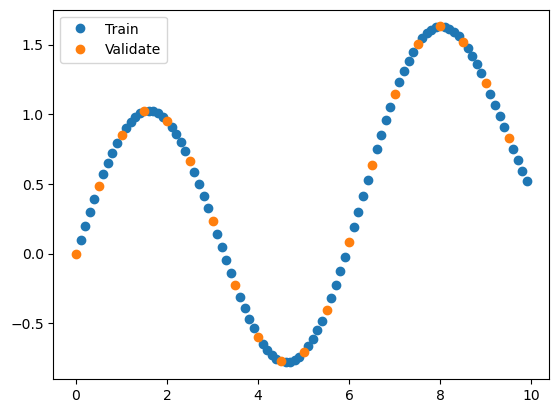

In [13]:
plt.plot(Xtrain, Ttrain, 'o', label='Train')
plt.plot(Xvalidate, Tvalidate, 'o', label='Validate')
plt.legend();

In [14]:
n_inputs = X.shape[1]
n_outputs = T.shape[1]

nnet = NeuralNetwork(n_inputs, [3, 2], n_outputs)
nnet  # using __repr__

NeuralNetwork(1, [3, 2], 1

In [15]:
nnet.n_inputs, nnet.n_hiddens_each_layer, nnet.n_outputs

(1, [3, 2], 1)

In [12]:
nnet.rmse_trace

[]

In [13]:
nnet.Ws

[array([[ 0.4269723 , -0.21070837,  0.04058303],
        [-0.35731978,  0.11585473, -0.13737671]]),
 array([[ 0.45198836, -0.50416932],
        [-0.50908213,  0.53812739],
        [ 0.26094578, -0.01084677],
        [ 0.35922418,  0.45293245]]),
 array([[0.],
        [0.],
        [0.]])]

In [14]:
nnet.set_weights_for_testing()

In [15]:
nnet.Ws

[array([[-0.31 , -0.106,  0.098],
        [-0.298, -0.094,  0.11 ]]),
 array([[-0.21      , -0.00714286],
        [-0.20428571, -0.00142857],
        [-0.19857143,  0.00428571],
        [-0.19285714,  0.01      ]]),
 array([[0.],
        [0.],
        [0.]])]

In [16]:
nnet.X_means

In [17]:
nnet.train(Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs=1, learning_rate=0.1, verbose=True)

Epoch is 0. # printed from _train
In _gradients, just before for loop.
Shapes of self.Zs elements: (80, 1), (80, 3), (80, 2), (80, 1)
In _gradients, just before for loop.
Shapes of self.Ws elements: (2, 3), (4, 2), (3, 1)
delta (backpropped from output layer) is  [[ 0.56472057]
 [ 0.43078542]
 [ 0.2992619 ]
 [ 0.1714574 ]
 [-0.06797693]
 [-0.17724141]
 [-0.2780798 ]
 [-0.36950481]
 [-0.52065815]
 [-0.57893022]
 [-0.62489089]
 [-0.65811469]
 [-0.68530256]
 [-0.67907596]
 [-0.65973309]
 [-0.62751445]
 [-0.52606497]
 [-0.45795576]
 [-0.37920288]
 [-0.29065392]
 [-0.08805168]
 [ 0.02384227]
 [ 0.14123522]
 [ 0.26287997]
 [ 0.51372308]
 [ 0.64025312]
 [ 0.76572495]
 [ 0.88879718]
 [ 1.12249669]
 [ 1.23059994]
 [ 1.33128073]
 [ 1.42343184]
 [ 1.57813906]
 [ 1.63893341]
 [ 1.68769214]
 [ 1.72381334]
 [ 1.7563581 ]
 [ 1.7522135 ]
 [ 1.73430073]
 [ 1.70267052]
 [ 1.59913072]
 [ 1.52798568]
 [ 1.44464468]
 [ 1.34979869]
 [ 1.12890892]
 [ 1.00477521]
 [ 0.87293759]
 [ 0.73455811]
 [ 0.44312276]
 

In [18]:
nnet.Zs

[array([[-1.73291748],
        [-1.55962573],
        [-1.38633399],
        [-1.21304224],
        [-1.03975049],
        [-0.86645874],
        [-0.69316699],
        [-0.51987524],
        [-0.3465835 ],
        [-0.17329175],
        [ 0.        ],
        [ 0.17329175],
        [ 0.3465835 ],
        [ 0.51987524],
        [ 0.69316699],
        [ 0.86645874],
        [ 1.03975049],
        [ 1.21304224],
        [ 1.38633399],
        [ 1.55962573]]),
 array([[ 3.90863485e-01,  1.13299913e-01, -1.83151701e-01],
        [ 3.00015774e-01,  8.10315818e-02, -1.46065385e-01],
        [ 2.03379207e-01,  4.85924892e-02, -1.08563919e-01],
        [ 1.02610753e-01,  1.60505622e-02, -7.07508843e-02],
        [-3.08708057e-04, -1.65254034e-02, -3.27334092e-02],
        [-1.03221630e-01, -4.90663238e-02,  5.37902499e-03],
        [-2.03971011e-01, -8.15034121e-02,  4.34758385e-02],
        [-3.00577512e-01, -1.13768758e-01,  8.14466324e-02],
        [-3.91386449e-01, -1.45795890e-01,  1.1918

Why only 20 rows in these matrices?  I thought I had 80 training samples!

Output: NeuralNetwork(1, [3, 2], 1 trained for 1 epochs with a final RMSE of 0.740178450121023.

In [19]:
print(nnet)  # using __str__

NeuralNetwork(1, [3, 2], 1 trained for 1 epochs with a final RMSE of 0.740178450121023.


In [20]:
nnet.X_means, nnet.X_stds

(array([5.]), array([2.88530761]))

In [21]:
nnet.T_means, nnet.T_stds

(array([0.51792742]), array([0.74017845]))

In [22]:
a = []
for Z in nnet.Zs:
    a.append(Z.shape)
a

[(20, 1), (20, 3), (20, 2), (20, 1)]

In [23]:
[Z.shape for Z in nnet.Zs]

[(20, 1), (20, 3), (20, 2), (20, 1)]

In [24]:
nnet.Ws

[array([[-0.62 , -0.212,  0.196],
        [-0.596, -0.188,  0.22 ]]),
 array([[-0.42      , -0.01428571],
        [-0.40857143, -0.00285714],
        [-0.39714286,  0.00857143],
        [-0.38571429,  0.02      ]]),
 array([[-1.55431223e-16],
        [-1.16781650e-01],
        [-2.64054414e-03]])]

In [25]:
dir(nnet)

['T_means',
 'T_stds',
 'Ws',
 'X_means',
 'X_stds',
 'Zs',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_ones',
 '_calc_rmse_standardized',
 '_forward',
 '_gradients',
 '_initialize_w',
 '_print_gradients_progress',
 '_standardize',
 '_start_gradients_message',
 'n_epochs',
 'n_hiddens_each_layer',
 'n_inputs',
 'n_outputs',
 'rmse_trace',
 'set_weights_for_testing',
 'train',
 'use']

In [26]:
def plot_data_and_model(nnet, Xtrain, Ttrain, Xvalidate, Tvalidate):
    n_layers = len(nnet.n_hiddens_each_layer)

    plt.subplot(2 + n_layers, 1, 1)
    plt.plot(nnet.rmse_trace)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend(('Train RMSE', 'Validate RMSE'))
                   
    plt.subplot(2 + n_layers , 1, 2)
    plt.plot(Xtrain, nnet.use(Xtrain), '-', label='Ytrain')
    plt.plot(Xtrain, Ttrain, 'o', label='Ttrain', alpha=0.5)

    plt.plot(Xvalidate, nnet.use(Xvalidate), '-', label='Yvalidate')
    plt.plot(Xvalidate, Tvalidate, 'o', label='Tvalidate', alpha=0.5)
    plt.xlabel('X')
    plt.ylabel('T or Y')
    plt.legend()

    Xs_for_plotting_Zs = np.linspace(Xtrain.min(), Xtrain.max(), 500).reshape(-1, 1)
    nnet.use(Xs_for_plotting_Zs)  # to set nnet.Zs to values for training data.
    for layeri, Z in enumerate(nnet.Zs[1:-1][::-1]):  # skip first element (just X) and last element (Y)
        plt.subplot(2 + n_layers, 1, layeri + 3)
        plt.plot(Z)
        plt.title(f'Outputs of Hidden Layer {n_layers - layeri}')
        plt.ylabel('Z')
        plt.xlabel('X')

In [27]:
X = np.arange(0, 10, 0.1).reshape(-1, 1)
T = np.sin(X) + 0.01 * (X ** 2)

rows = np.arange(X.shape[0])
# Collect every 10th sample as the test set.
rows_validate = rows[::10]
# All remaining samples are in the train set.
rows_train = np.setdiff1d(rows, rows_validate)

Xtrain = X[rows_train, :]
Ttrain = T[rows_train, :]
Xvalidate = X[rows_validate, :]
Tvalidate = T[rows_validate, :]

n_inputs = X.shape[1]
n_hiddens_each_layer = [10, 5]
n_outputs = T.shape[1]

nnet = NeuralNetwork(n_inputs, n_hiddens_each_layer, n_outputs)
nnet.set_weights_for_testing()

n_epochs = 10000
n_epochs_per_plot = 200

fig = plt.figure(figsize=(8, 10))
for reps in range(n_epochs // n_epochs_per_plot):
    plt.clf()
    nnet.train(Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs=n_epochs_per_plot, learning_rate=0.2, verbose=True)
    plot_data_and_model(nnet, Xtrain, Ttrain, Xvalidate, Tvalidate)
    plt.tight_layout()
    ipd.clear_output(wait=True)
    ipd.display(fig)
ipd.clear_output(wait=True)


Epoch is 0. # printed from _train
In _gradients, just before for loop.
Shapes of self.Zs elements: (90, 1), (90, 10), (90, 5), (90, 1)
In _gradients, just before for loop.
Shapes of self.Ws elements: (2, 10), (11, 5), (6, 1)
delta (backpropped from output layer) is  [[ 0.5659438 ]
 [ 0.43194551]
 [ 0.30035998]
 [ 0.17249522]
 [ 0.04961938]
 [-0.06705199]
 [-0.17636798]
 [-0.27725391]
 [-0.36872202]
 [-0.51994663]
 [-0.57824617]
 [-0.62422851]
 [-0.65746798]
 [-0.67766892]
 [-0.68466866]
 [-0.67843913]
 [-0.65908714]
 [-0.62685331]
 [-0.52535599]
 [-0.45721468]
 [-0.37842466]
 [-0.28983396]
 [-0.19239121]
 [-0.0871362 ]
 [ 0.0248105 ]
 [ 0.14225879]
 [ 0.26396089]
 [ 0.51492227]
 [ 0.64151196]
 [ 0.76704295]
 [ 0.8901732 ]
 [ 1.00958194]
 [ 1.12398289]
 [ 1.2321371 ]
 [ 1.33286536]
 [ 1.42505992]
 [ 1.57984008]
 [ 1.64066308]
 [ 1.6894448 ]
 [ 1.72558304]
 [ 1.7485992 ]
 [ 1.75814314]
 [ 1.75399658]
 [ 1.73607536]
 [ 1.70443025]
 [ 1.60084163]
 [ 1.52966305]
 [ 1.44628275]
 [ 1.35139205

ValueError: operands could not be broadcast together with shapes (90,5) (90,9) 

<Figure size 800x1000 with 0 Axes>

In [ ]:
X = np.arange(-2, 2, 0.02).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10) + 0.1 * (X + 2)

rows = np.arange(X.shape[0])
rows_validate = rows[::10]
rows_train = np.setdiff1d(rows, rows_validate)

Xtrain = X[rows_train, :]
Ttrain = T[rows_train, :]
Xvalidate = X[rows_validate, :] 
Tvalidate = T[rows_validate, :] * 0.7

n_inputs = X.shape[1]
n_hiddens_each_layer = [50, 10, 5]
n_outputs = T.shape[1]

nnet = NeuralNetwork(n_inputs, n_hiddens_each_layer, n_outputs)
nnet.set_weights_for_testing()

n_epochs = 50_000
n_epochs_per_plot = 500

fig = plt.figure(figsize=(8, 10))
for reps in range(n_epochs // n_epochs_per_plot):
    plt.clf()
    nnet.train(Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs=n_epochs_per_plot, learning_rate=0.05)
    plot_data_and_model(nnet, Xtrain, Ttrain, Xvalidate, Tvalidate)
    plt.tight_layout()
    ipd.clear_output(wait=True)
    ipd.display(fig)
ipd.clear_output(wait=True)

Don't forget to test a neural network with no hidden layers, one hidden layer with a single unit, and other tests you are curious about.

## Application of `NeuralNetwork` class to some data related to the energy efficiency of buildings!

Download data from [Energy Efficiency at the UCI ML Repository](https://archive.ics.uci.edu/dataset/242/energy+efficiency). Read it into python using the `pandas.read_csv` function.  Assign the first 8 columns as inputs to `X` and the final two columns as target values to `T`.  Make sure `T` is two-dimensional with two columns.

In [16]:
import pandas

# Read the xlsx file as a pandas.DataFrame
data_df = pandas.read_excel('ENB2012_data.xlsx')
data = data_df.values

From the information at the UCI site, we see these are the names of the input and target components.

In [17]:
Xnames = ['Relative Compactness',
    	  'Surface Area',
    	  'Wall Area',
          'Roof Area',
    	  'Overall Height',
          'Orientation',
    	  'Glazing Area',
    	  'Glazing Area Distribution']

Tnames = ['Heating Load',
    	  'Cooling Load']

In [18]:
Xnames, Tnames

(['Relative Compactness',
  'Surface Area',
  'Wall Area',
  'Roof Area',
  'Overall Height',
  'Orientation',
  'Glazing Area',
  'Glazing Area Distribution'],
 ['Heating Load', 'Cooling Load'])

In [19]:
X = data[:, :8]
T = data[:, 8:]
X.shape, T.shape

((768, 8), (768, 2))

In [20]:
rows = np.arange(X.shape[0])
np.random.shuffle(rows)
train_fraction = 0.8
ntrain = round(X.shape[0] * train_fraction)
Xtrain = X[rows[:ntrain], :]
Ttrain = T[rows[:ntrain], :]
Xvalidate = X[rows[ntrain:], :]
Tvalidate = T[rows[ntrain:], :]
Xtrain.shape, Ttrain.shape, Xvalidate.shape, Tvalidate.shape

((614, 8), (614, 2), (154, 8), (154, 2))

Now, write a function names `create_model` that accepts `n_hiddens_each_layer`, `n_epochs`, and `learning_rate` and that creates and trains a neural network with the correct number of inputs and outputs and the given value of `n_hiddens_each_layer`.  Add a few lines to apply the trained network with the `use` function on the `Xtrain` and `Xvalidate` data and calculates the RMSE for each. Have your function return the neural network and the two output arrays, `Ytrain` and `Yvalidate`.

In [21]:
def rmse(T, Y):
    error = (T - Y) 
    return np.sqrt(np.mean(error ** 2))

def create_model(Xtrain, Ttrain, Xvalidate, Tvalidate, n_hiddens_each_layer, n_epochs, learning_rate):
    # create and train Neural Network
    n_inputs = Xtrain.shape[1]
    n_outputs = Ttrain.shape[1]
    nnet = NeuralNetwork(n_inputs, n_hiddens_each_layer, n_outputs)
    nnet.train(Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs, learning_rate, verbose=True)
    
    # Apply NN to train and validation data
    Ytrain = nnet.use(Xtrain)
    Yvalidate = nnet.use(Xvalidate)
    
    train_rmse = rmse(T=Ttrain, Y=Ytrain)
    validate_rmse = rmse(T=Tvalidate, Y=Yvalidate)
    
    print('Train RMSE: {}'.format(train_rmse))
    print('Validation RMSE: {}'.format(validate_rmse))
    
    return nnet, Ytrain, Yvalidate
    

In [22]:
n_hiddens_each_layer = [3, 2, 1]
n_epochs=3
learning_rate = 0.001

nnet, Ytrain, Yvalidate = create_model(Xtrain, Ttrain, Xvalidate, Tvalidate, n_hiddens_each_layer, n_epochs, learning_rate)

Epoch is 0. # printed from _train
In _gradients, just before for loop.
Shapes of self.Zs elements: (614, 8), (614, 3), (614, 2), (614, 1), (614, 2)
In _gradients, just before for loop.
Shapes of self.Ws elements: (9, 3), (4, 2), (3, 1), (2, 2)
delta (backpropped from output layer) is  [[ 0.23342329  0.23020425]
 [ 0.39059655  0.3342755 ]
 [ 0.0352807  -0.02072899]
 ...
 [ 0.12888942  0.20590334]
 [-0.17180066 -0.13985624]
 [-0.24504886 -0.34879117]]
gradients list is empty.

layer:  3
Current activations shape: (614, 1)
Current error shape: (614, 2)
Weight gradient shape: (1, 2)
Full gradient shape: (2, 2)
Shape of prev_activation: (614, 1)
shape of error: (614, 1)
Propagated error shape: (614, 1)
End of Pass 1 through _gradients for loop:
shapes of elements in gradients list are (2, 2)
shapes of updated delta is (614, 1)
element 1 of gradients list is: [[-4.53637128e-13 -4.43978188e-13]
 [-1.01510688e+01 -9.37498130e+00]]


layer:  2
Current activations shape: (614, 2)
Current error s

ValueError: operands could not be broadcast together with shapes (614,3) (614,7) 

Starting with the following code to plot your results, add another four plots in two rows below these that plot the predicted values on the y axis and the target values on the x axis.  Add labels to all x and y axes that appear in this figure.

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(nnet.rmse_trace)

plt.subplot(3, 2, 3)
plt.plot(Ttrain[:, 0],  label='Ttrain')
plt.plot(Ytrain[:, 0],  label='Ytrain')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(Tvalidate[:, 0], label='Tvalidate')
plt.plot(Yvalidate[:, 0], label='Yvalidate')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(Ttrain[:, 1], label='Ttrain')
plt.plot(Ytrain[:, 1], label='Ytrain')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(Tvalidate[:, 1], label='Tvalidate')
plt.plot(Yvalidate[:, 1], label='Yvalidate')
plt.legend();

Run the previous two code cells several times with different values for `n_hiddens_each_layer`, `n_epochs`, and `learning_rate` until you have values that you think work pretty well.

In a markdown cell, write at least four sentences answering each of the following questions.

1. How is the training RMSE curve affected by the number of hidden layers and the number of units in each layer?
2. How is the final training and validation RMSE affected by the number of epochs and learning rate?
3. How much do the final training and validation RMSE values vary for different training runs that differ only in the intial random weights?
4. How well does your best model do in predicting heading and cooling load?  In other words, what does an RMSE of a particular value mean in relation to the target values?
5. What was the hardest part of this assignment?  What is an estimate of the number of hours you spent on this assignment?

I unfortunately have been unable to get my _gradients function to run for any network architecture and have hit the submission time. I have been unable to get create_model function to run for my NeuralNet implementation and have run out of time to debug it. I will try to answer these questions with what I hypothesize would occur.

1. I suspect the _training_ RMSE curve will improve very close to 0.0 with the more layers and units that we add. This is because I suspect there will be a large amount of overfitting to the training data. I don't think increasing the number of layers and units exponentially would improve the RMSE of validation or testing data though.

2. The more epochs, the lower the training RMSE will get. But the Validation RMSe will stop improving at some point once the model starts overfitting to the training data. Lowering the learning rate will slow down the training time, as the weights will be updated by smaller increments. Increasing the learning rate may prevent us from ever converging on the minimum error that we're looking for. Large learning rates can cause the weight values to jump around sporadically and skip over the minimas.

3. I would guess quite a lot. Weight initialization has a large impact on how the model performs. If weights are initialized very poorly it's possible to end up with very poor results from a well designed model.

4. 

5. Definitely the _gradients function, but also making sure the matrix math and dimensions lined up. I probably have spent around 30 hours on this assignment.

# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A2grader.zip](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A2grader.zip) and unzip `A2grader.py` from it. Run the code in the following cell to demonstrate an example grading session.

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as `A2solution.ipynb`, and then save this notebook.  Check in your `A2solution.ipynb` notebook when you are ready.

In [ ]:
%run -i A2grader.py

# Extra Credit (maximum of 2 points)

Which inputs does your trained neural network find to be most signficant?  

## Extra Credit (up to 1 point)

There are many ways to answer this.  For this extra credit, print the absolute values of the weights in the first hidden layer for all units in that layer.  The "all units" is the hard part.  Try just taking the mean of the absolute values of the weights for each input across all units.  Do the results make sense to you?

## Extra Credit (up to 1 point)

Try using a `matplotlib.pyplot` call like

```
plt.imshow(np.abs(nnet.Ws[0]), interpolation='nearest')
plt.colorbar()
```

to see if you can visually see patterns in the weight magnitudes.  Describe what you see.